<a href="https://colab.research.google.com/github/fintechsteve/modeling-volatility/blob/master/Part_04_Understanding_Turbulence_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part ??: Understanding GARCH Estimation

### In this section you will:


*   Learn about GARCH estimation and its use in investment management
*   Fit a GARCH Model to currency data
*   Use a GARCH Model forecast volitility


### Intro

GARCH (Generalized Autoregressive Conditional Heteroskedastic) Estimation is used to model the variance of a time series.  Applied to investment management, a GARCH model can be used to model, and therefore predict, asset volatility.

?? include citations 
Engle, Robert F. (1982). "Autoregressive Conditional Heteroscedasticity with Estimates of the Variance of United Kingdom Inflation". Econometrica. 50 (4): 987–1007. doi:10.2307/1912773. JSTOR 1912773.
Bollerslev, Tim (1986). "Generalized Autoregressive Conditional Heteroskedasticity". Journal of Econometrics. 31 (3): 307–327. CiteSeerX 10.1.1.468.2892. doi:10.1016/0304-4076(86)90063-1.
??

Consider first an ARCH (Autoregressive Conditional Heteroskedastic) model.  This model assumes that the variance at time $t$ ($\sigma^2_t$) depends linearly on the error $\epsilon_t$,  at a fixed number ($q$) of previous time periods.  When ${q = 1}$ and assuming that the time series ${r_t}$  is stationary with constant mean ${\mu}$ we have the ARCH(1) model:

\begin{eqnarray*}
   r_t    & = & \mu + \epsilon_t \\
   \epsilon_t & = & \sigma_t e_t \\
   \sigma^2_t & = & \omega + \alpha \epsilon_{t-1}^2
\end{eqnarray*}

More generally for ${q > 1}$ we have ARCH(q):

\begin{eqnarray*}
   \sigma^2_t & = & \omega + \sum_{i=1}^{q}\alpha_i \epsilon_{t-i}^2 
\end{eqnarray*}

The ARCH model captures the idea that the volatility of the series may change through time.  For example ( give financial example with short period of high vol). A time series that exhibits periods with increased (or decreased) volatility is called conditional heteroskedastic. 

The ARCH model may be extended to a GARCH model by adding linear dependance on a fixed number ($p$) of past variances.  For ${p = 1}$  and ${q = 1}$ the GARCH(1,1) model is

\begin{eqnarray*}
   r_t    & = & \mu + \epsilon_t \\
   \epsilon_t & = & \sigma_t e_t \\
   \sigma^2_t & = & \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1}
\end{eqnarray*}

More generally for ${p > 1}$ and ${q > 1}$ we have GARCH(p,q):

\begin{eqnarray*}
   \sigma^2_t & = & \omega + \sum_{i=1}^{q}\alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p}\beta_j \sigma^2_{t-j}
\end{eqnarray*}

## Import all necessary libraries

For this piece, we will need the following packages to be available to our environment:

*   Numpy and Pandas (For data manipulation)
*   Arch (For GARCH estimation)

If the packages are not available, install the with "pip install X"

In [1]:
import numpy as np, pandas as pd
import pickle
from arch import arch_model

### Read in data from previously stored returns.pkl file



In [5]:
with open('./returns.pkl', 'rb') as f:
    returns = pickle.load(f)
    f.close()
returns.head(10)

,AUD,CAD,CHF,EUR,GBP,JPY,NOK,NZD,SEK
1975-01-02,-0.002129,-1.712061e-03,-0.009915,-0.003544,-0.005745,-0.001502,-0.003299,0.000536,-0.004704
1975-01-03,-0.000947,1.517425e-05,0.008500,0.007886,0.003424,0.002711,0.008801,-0.001924,0.007113
1975-01-06,-0.001158,6.677374e-04,-0.001023,0.008174,0.002346,-0.004728,0.002759,-0.001129,0.009237
1975-01-07,0.004193,-1.726304e-03,0.001702,0.002150,0.001702,0.002410,0.005434,0.004567,-0.001466
1975-01-08,-0.001489,-2.000930e-04,-0.015237,-0.008650,-0.001997,0.000122,-0.006315,-0.000034,-0.006188
1975-01-09,-0.000324,-3.120108e-03,0.000298,0.004764,0.000298,-0.000409,-0.000114,-0.001217,-0.000751
1975-01-10,0.000077,-1.283429e-03,0.001489,0.001489,0.001489,0.000075,0.006256,0.000311,0.001489
1975-01-13,0.000579,-3.152212e-07,0.001789,-0.001210,0.000127,-0.000578,0.000542,0.000969,-0.002488
1975-01-14,-0.000699,7.303998e-04,-0.005132,-0.006698,-0.001827,0.000291,-0.006558,-0.000762,-0.007795
1975-01-15,-0.000934,1.198868e-03,-0.002078,0.001797,-0.000426,-0.002542,-0.002276,-0.000594,0.000094


### Calculate DXY Index
**Note: this should probably be saved in part 2 rather than recaluated

In this part we scale the DXY Index to avoid numerical instabilities in the model fitting that may arise for inputs near zero.

In [7]:
dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = returns.dot(dxy_weight)
scaled_dxy = 100*dxy
scaled_dxy.head(10)

1975-01-02   -0.263509
1975-01-03    0.298223
1975-01-06   -0.152101
1975-01-07    0.134179
1975-01-08   -0.133663
1975-01-09   -0.062415
1975-01-10    0.028212
1975-01-13   -0.047792
1975-01-14   -0.088794
1975-01-15   -0.144571
dtype: float64

### Estimate a GARCH(1,1) model for the DXY Index

In [49]:
am = arch_model(scaled_dxy, mean = 'Constant', vol='GARCH', p=1, q=1)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     40,   Neg. LLF: 6811.526379279518
Iteration:     10,   Func. Count:     81,   Neg. LLF: 6805.28464578078
Iteration:     15,   Func. Count:    116,   Neg. LLF: 6797.496139704385
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6797.351618871784
            Iterations: 19
            Function evaluations: 136
            Gradient evaluations: 18
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -6797.35
Distribution:                  Normal   AIC:                           13602.7
Method:            Maximum Likelihood   BIC:                           13632.0
                                        No. Observations:                11214
Date:                

The above model corresponds to ${\alpha  = .0422}$,  ${\beta = .9552}$, ${\omega = 9.5954e-04}$ and ${\mu = 1.8657e-03}$ in the frame work described above

\begin{eqnarray}
   r_t    & = & \mu + \epsilon_t \\
   \epsilon_t & = & \sigma_t e_t \\
   \sigma^2_t & = & \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1}
\end{eqnarray}


### Forecast volitility for the DXY Index

Now we can use this model to forecast the future variance

In [55]:
forecasts = res.forecast(horizon = 1)
print(forecasts.variance.index[-1])
print(forecasts.variance.values[-1, -1])

2017-12-26 00:00:00
0.0871872134006


Next we use a rolling window to forecast the one day volitility for the last 100 days of our sample.  For each of the 100 days we use the prior 250 days to fit a GARCH model and forecast a one day horizon.

,date,var
0,2017-08-09,0.175976
1,2017-08-10,0.175047
2,2017-08-11,0.168307
3,2017-08-14,0.168621
4,2017-08-15,0.186811
5,2017-08-16,0.180792
6,2017-08-17,0.186759
7,2017-08-18,0.194278
8,2017-08-21,0.189412
9,2017-08-22,0.198055


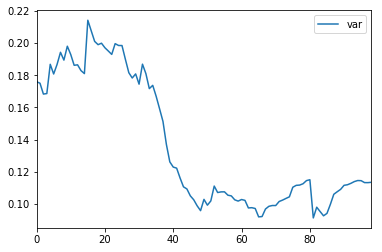

In [44]:
lookback_window = 250
f = []
for i in range(1,100):
    am = arch_model(scaled_dxy[-i-lookback_window:-i], mean = 'Constant', vol='GARCH', p=1, q=1)
    res = am.fit(disp='off')
    forecasts = res.forecast(horizon = 1)
    f.append({'var': forecasts.variance.iloc[-1, -1], 'date':forecasts.variance.index[-1]})
    
d = pd.DataFrame(f[::-1])
d.plot()
d.head(10)

### Selecting values for p and q

picking p and q?  also look back window, goodness of fit, etc.?